In [1]:
# !pip install -U spacy
# !python -m spacy download en_core_web_sm

In [2]:
import nltk
from sklearn.metrics import classification_report, accuracy_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy import sparse
import re
import numpy as np
import math
import pandas as pd
import glob
from sklearn.svm import SVC
import os
import joblib
import wordninja
import spacy
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from spellchecker import SpellChecker

import language_tool_python

In [3]:
nltk.download('punkt')              
nltk.download('stopwords')        
nltk.download('wordnet')              
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
def load_reddit_dataset(data_path, s_size=None, text_column="selftext", label_column="subreddit"):

    csv_files = glob.glob(os.path.join(data_path, "**", "*.csv"), recursive=True)
    print(f"Found {len(csv_files)} CSV files.")

    all_dataframes = []
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            all_dataframes.append(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")

    all_data = pd.concat(all_dataframes, ignore_index=True)
    print("Total rows before cleaning:", len(all_data))

    clear_data = all_data.dropna(subset=[text_column, label_column])
    print("Total rows after dropping NA:", len(clear_data))

    if s_size is not None:
        grouped = clear_data.groupby(label_column)
        eligible_groups = [name for name, group in grouped if len(group) >= s_size]
        filtered_data = clear_data[clear_data[label_column].isin(eligible_groups)]
        df_sampled = filtered_data.groupby(label_column).sample(n=s_size, random_state=42)
        df_sampled = df_sampled.reset_index(drop=True)
        print("Sampled class distribution:")
        print(df_sampled[label_column].value_counts())
    else:
        df_sampled = clear_data
        print("Returned all available data without sampling.")
        print(df_sampled[label_column].value_counts())

    return df_sampled[text_column], df_sampled[label_column]

In [5]:
text_data, label_data = load_reddit_dataset("dataset", s_size=8000)

Found 223 CSV files.
Total rows before cleaning: 1852403
Total rows after dropping NA: 1797816
Sampled class distribution:
subreddit
Anxiety         8000
SuicideWatch    8000
depression      8000
lonely          8000
mentalhealth    8000
Name: count, dtype: int64


In [6]:
print(text_data.iloc[0])
len(text_data)  

A few weeks ago, I finally caved and called my doctor to get back on my anxiety medicine after my anxiety got so bad that I was having panic attacks whenever I left the house. I cried picking it up. I was so ready to feel normal again. 

Well last night I went to the store and felt an anxiety attack coming. Instead of spiraling out of control like I have been, I was easily able to calm down. I can't share this with anyone else so I thought to post it here. I am so happy that I was able to finish shopping and that I didn't end up with a panic attack. 

I don't know why I waited so long to go back on my medicine.


40000

In [7]:
label_data

0             Anxiety
1             Anxiety
2             Anxiety
3             Anxiety
4             Anxiety
             ...     
39995    mentalhealth
39996    mentalhealth
39997    mentalhealth
39998    mentalhealth
39999    mentalhealth
Name: subreddit, Length: 40000, dtype: object

In [8]:
def clean_data(data):
    html_regex = re.compile("<.*?>")
    num_regex = re.compile("\d+")
    pun_re = re.compile("[^\w\s]")

    cleaned_data = []

    for text in data:
        text = re.sub(html_regex, '', text)

        urls = re.findall(r'https?://\S+|www\.\S+', text)
        for url in urls:
            tokens = re.findall(r'[a-zA-Z]{4,}', url)
            if len(tokens) >= 3:
                text = text.replace(url, ' '.join(tokens))
            else:
                text = text.replace(url, '[URL]')

        text = re.sub(num_regex, '', text)

        text = re.sub(pun_re, '', text)

        cleaned_data.append(text)

    return cleaned_data



text_data01 = clean_data(text_data)

text_data01[0]

'A few weeks ago I finally caved and called my doctor to get back on my anxiety medicine after my anxiety got so bad that I was having panic attacks whenever I left the house I cried picking it up I was so ready to feel normal again \n\nWell last night I went to the store and felt an anxiety attack coming Instead of spiraling out of control like I have been I was easily able to calm down I cant share this with anyone else so I thought to post it here I am so happy that I was able to finish shopping and that I didnt end up with a panic attack \n\nI dont know why I waited so long to go back on my medicine'

In [9]:
tool = language_tool_python.LanguageTool('en-US')

def correct_text_languagetool(text):
    matches = tool.check(text)
    corrected_text = language_tool_python.utils.correct(text, matches)
    return corrected_text

def correct_texts_languagetool(text_list):
    corrected_texts = []
    for text in text_list:
        corrected_text = correct_text_languagetool(text)
        corrected_texts.append(corrected_text)
    return corrected_texts

text_data_corrected = correct_texts_languagetool(text_data01)

print(text_data_corrected[0])

A few weeks ago I finally caved and called my doctor to get back on my anxiety medicine after my anxiety got so bad that I was having panic attacks whenever I left the house I cried picking it up I was so ready to feel normal again 

Well last night I went to the store and felt an anxiety attack coming Instead of spiraling out of control like I have been I was easily able to calm down I can't share this with anyone else, so I thought to post it here I am so happy that I was able to finish shopping and that I didn't end up with a panic attack 

I don't know why I waited so long to go back on my medicine


In [10]:
def splited_data(data):
    temp_data = []
    for corpus in data:
        words = " ".join(corpus.split()).split()
        fixed_words = []

        for word in words:
            if len(word) > 30:
                split_words = wordninja.split(word)
                fixed_words.extend(split_words)
            else:
                fixed_words.append(word)

        temp_data.append(fixed_words)

    return temp_data



text_data02 = splited_data(text_data_corrected)

text_data02[0]

['A',
 'few',
 'weeks',
 'ago',
 'I',
 'finally',
 'caved',
 'and',
 'called',
 'my',
 'doctor',
 'to',
 'get',
 'back',
 'on',
 'my',
 'anxiety',
 'medicine',
 'after',
 'my',
 'anxiety',
 'got',
 'so',
 'bad',
 'that',
 'I',
 'was',
 'having',
 'panic',
 'attacks',
 'whenever',
 'I',
 'left',
 'the',
 'house',
 'I',
 'cried',
 'picking',
 'it',
 'up',
 'I',
 'was',
 'so',
 'ready',
 'to',
 'feel',
 'normal',
 'again',
 'Well',
 'last',
 'night',
 'I',
 'went',
 'to',
 'the',
 'store',
 'and',
 'felt',
 'an',
 'anxiety',
 'attack',
 'coming',
 'Instead',
 'of',
 'spiraling',
 'out',
 'of',
 'control',
 'like',
 'I',
 'have',
 'been',
 'I',
 'was',
 'easily',
 'able',
 'to',
 'calm',
 'down',
 'I',
 "can't",
 'share',
 'this',
 'with',
 'anyone',
 'else,',
 'so',
 'I',
 'thought',
 'to',
 'post',
 'it',
 'here',
 'I',
 'am',
 'so',
 'happy',
 'that',
 'I',
 'was',
 'able',
 'to',
 'finish',
 'shopping',
 'and',
 'that',
 'I',
 "didn't",
 'end',
 'up',
 'with',
 'a',
 'panic',
 'attack'

In [11]:
def lowercase(data):
    data_lowercase = []

    for corpus in data:
        temp_list = []
        for word in corpus:
            temp = word.lower()
            temp_list.append(temp)

        data_lowercase.append(temp_list)

    return data_lowercase


text_data03 = lowercase(text_data02)
text_data03[0]

['a',
 'few',
 'weeks',
 'ago',
 'i',
 'finally',
 'caved',
 'and',
 'called',
 'my',
 'doctor',
 'to',
 'get',
 'back',
 'on',
 'my',
 'anxiety',
 'medicine',
 'after',
 'my',
 'anxiety',
 'got',
 'so',
 'bad',
 'that',
 'i',
 'was',
 'having',
 'panic',
 'attacks',
 'whenever',
 'i',
 'left',
 'the',
 'house',
 'i',
 'cried',
 'picking',
 'it',
 'up',
 'i',
 'was',
 'so',
 'ready',
 'to',
 'feel',
 'normal',
 'again',
 'well',
 'last',
 'night',
 'i',
 'went',
 'to',
 'the',
 'store',
 'and',
 'felt',
 'an',
 'anxiety',
 'attack',
 'coming',
 'instead',
 'of',
 'spiraling',
 'out',
 'of',
 'control',
 'like',
 'i',
 'have',
 'been',
 'i',
 'was',
 'easily',
 'able',
 'to',
 'calm',
 'down',
 'i',
 "can't",
 'share',
 'this',
 'with',
 'anyone',
 'else,',
 'so',
 'i',
 'thought',
 'to',
 'post',
 'it',
 'here',
 'i',
 'am',
 'so',
 'happy',
 'that',
 'i',
 'was',
 'able',
 'to',
 'finish',
 'shopping',
 'and',
 'that',
 'i',
 "didn't",
 'end',
 'up',
 'with',
 'a',
 'panic',
 'attack'

In [12]:
def remove_stopwords(data):

    res_data = []
    for corpus in data:
        temp_list=[]
        for word in corpus:
            if word not in stopwords.words("english") :
                temp_list.append(word)

        res_data.append(temp_list)

    return res_data
text_data04 = remove_stopwords(text_data03)



text_data04[0]

['weeks',
 'ago',
 'finally',
 'caved',
 'called',
 'doctor',
 'get',
 'back',
 'anxiety',
 'medicine',
 'anxiety',
 'got',
 'bad',
 'panic',
 'attacks',
 'whenever',
 'left',
 'house',
 'cried',
 'picking',
 'ready',
 'feel',
 'normal',
 'well',
 'last',
 'night',
 'went',
 'store',
 'felt',
 'anxiety',
 'attack',
 'coming',
 'instead',
 'spiraling',
 'control',
 'like',
 'easily',
 'able',
 'calm',
 "can't",
 'share',
 'anyone',
 'else,',
 'thought',
 'post',
 'happy',
 'able',
 'finish',
 'shopping',
 'end',
 'panic',
 'attack',
 'know',
 'waited',
 'long',
 'go',
 'back',
 'medicine']

In [13]:
nlp = spacy.load("en_core_web_sm")

def pos_spacy(data):
    pos_list = []
    for tokens in data:
        doc = nlp(" ".join(tokens))
        pos_tags = [(token.text, token.pos_) for token in doc]
        pos_list.append(pos_tags)
    return pos_list


text_data06 = pos_spacy(text_data04)

In [14]:
text_data06[0]

[('weeks', 'NOUN'),
 ('ago', 'ADV'),
 ('finally', 'ADV'),
 ('caved', 'VERB'),
 ('called', 'VERB'),
 ('doctor', 'NOUN'),
 ('get', 'VERB'),
 ('back', 'ADV'),
 ('anxiety', 'NOUN'),
 ('medicine', 'NOUN'),
 ('anxiety', 'NOUN'),
 ('got', 'VERB'),
 ('bad', 'ADJ'),
 ('panic', 'NOUN'),
 ('attacks', 'NOUN'),
 ('whenever', 'SCONJ'),
 ('left', 'ADJ'),
 ('house', 'PROPN'),
 ('cried', 'VERB'),
 ('picking', 'VERB'),
 ('ready', 'ADJ'),
 ('feel', 'VERB'),
 ('normal', 'ADJ'),
 ('well', 'ADV'),
 ('last', 'ADJ'),
 ('night', 'NOUN'),
 ('went', 'VERB'),
 ('store', 'NOUN'),
 ('felt', 'VERB'),
 ('anxiety', 'NOUN'),
 ('attack', 'NOUN'),
 ('coming', 'VERB'),
 ('instead', 'ADV'),
 ('spiraling', 'VERB'),
 ('control', 'NOUN'),
 ('like', 'ADP'),
 ('easily', 'ADV'),
 ('able', 'ADJ'),
 ('calm', 'NOUN'),
 ('ca', 'AUX'),
 ("n't", 'PART'),
 ('share', 'VERB'),
 ('anyone', 'PRON'),
 ('else', 'ADV'),
 (',', 'PUNCT'),
 ('thought', 'VERB'),
 ('post', 'VERB'),
 ('happy', 'ADJ'),
 ('able', 'ADJ'),
 ('finish', 'NOUN'),
 ('shopp

In [15]:
def fix_negations(data):
    fixed_data = []
    negation_starters = ['ca', 'do', 'did', 'wo', 'sha', 'is', 'was', 'would', 'could', 'should', 'might', 'must']

    i = 0
    while i < len(data):
        if (i + 1 < len(data) and
            data[i][0].lower() in negation_starters and
            data[i+1][0].lower() == "n't"):
            
            combined_word = data[i][0] + "n't"
            fixed_data.append((combined_word, data[i][1]))
            i += 2
        else:
            fixed_data.append(data[i])
            i += 1

    return fixed_data

def lemmatizing(data):
    wnl = WordNetLemmatizer()
    lemmatize_data = []

    tag = {
        "NOUN": "n",
        "VERB": "v",
        "ADJ": "a",
        "ADV": "r"
    }

    for corpus in data:
        corpus_fixed = fix_negations(corpus)
        temp_list = []

        for word in corpus_fixed:
            pos_tag = tag.get(word[1], None)
            if pos_tag:
                lemma = wnl.lemmatize(word[0], pos=pos_tag)
            else:
                lemma = word[0]
            temp_list.append(lemma)

        lemmatize_data.append(temp_list)

    return lemmatize_data

text_data07 = lemmatizing(text_data06)

In [16]:
text_data07[0]

['week',
 'ago',
 'finally',
 'cave',
 'call',
 'doctor',
 'get',
 'back',
 'anxiety',
 'medicine',
 'anxiety',
 'get',
 'bad',
 'panic',
 'attack',
 'whenever',
 'left',
 'house',
 'cry',
 'pick',
 'ready',
 'feel',
 'normal',
 'well',
 'last',
 'night',
 'go',
 'store',
 'felt',
 'anxiety',
 'attack',
 'come',
 'instead',
 'spiral',
 'control',
 'like',
 'easily',
 'able',
 'calm',
 "can't",
 'share',
 'anyone',
 'else',
 ',',
 'think',
 'post',
 'happy',
 'able',
 'finish',
 'shopping',
 'end',
 'panic',
 'attack',
 'know',
 'wait',
 'long',
 'go',
 'back',
 'medicine']

In [17]:
def vectorize_tfidf(text_data):
    joined_texts = [" ".join(doc) for doc in text_data]

    vectorizer = TfidfVectorizer(
        max_features=500,
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.85
    )

    X_tfidf = vectorizer.fit_transform(joined_texts)
    return X_tfidf, vectorizer

X_tfidf, tfidf_vec = vectorize_tfidf(text_data07)
print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (40000, 500)


In [18]:
def prepare_data(X, labels, test_size=0.2, random_state=42):
    encoder = LabelEncoder()
    y = encoder.fit_transform(labels)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    return X_train, X_test, y_train, y_test, encoder


In [19]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf, enc_tfidf = prepare_data(X_tfidf, label_data)



print("SpaCy:", X_train_tfidf.shape, X_test_tfidf.shape)
print("Label classes:", enc_tfidf.classes_)


SpaCy: (32000, 500) (8000, 500)
Label classes: ['Anxiety' 'SuicideWatch' 'depression' 'lonely' 'mentalhealth']


In [20]:

def print_top_tfidf_features(X_tfidf, vectorizer, top_n=20):
    tfidf_means = np.asarray(X_tfidf.mean(axis=0)).ravel()
    
    top_n_ids = tfidf_means.argsort()[::-1][:top_n]
    
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    print(f"Top {top_n} TF-IDF features:")
    for idx in top_n_ids:
        print(f"{feature_names[idx]}: {tfidf_means[idx]:.4f}")

print_top_tfidf_features(X_tfidf, tfidf_vec, top_n=20)


Top 20 TF-IDF features:
remove: 0.0798
feel: 0.0638
like: 0.0584
get: 0.0514
want: 0.0509
go: 0.0480
know: 0.0450
time: 0.0364
life: 0.0355
make: 0.0351
friend: 0.0350
people: 0.0350
think: 0.0347
can: 0.0332
even: 0.0320
really: 0.0319
day: 0.0313
one: 0.0299
thing: 0.0298
anxiety: 0.0298


In [21]:
def train_tfidf_models(X_train, X_test, y_train, y_test):
    print(" TF-IDF → Logistic Regression")
    model_lr = LogisticRegression(max_iter=100)
    model_lr.fit(X_train, y_train)
    preds_lr = model_lr.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, preds_lr))
    print(classification_report(y_test, preds_lr))

    print(" TF-IDF → SVM")
    model_svm = SVC()
    model_svm.fit(X_train, y_train)
    preds_svm = model_svm.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, preds_svm))
    print(classification_report(y_test, preds_svm))

    return model_svm, model_lr


In [22]:
# TF-IDF
model_svm, model_lr = train_tfidf_models(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf)

 TF-IDF → Logistic Regression
Accuracy: 0.56425
              precision    recall  f1-score   support

           0       0.73      0.70      0.71      1600
           1       0.55      0.55      0.55      1600
           2       0.41      0.43      0.42      1600
           3       0.62      0.69      0.65      1600
           4       0.51      0.46      0.48      1600

    accuracy                           0.56      8000
   macro avg       0.57      0.56      0.56      8000
weighted avg       0.57      0.56      0.56      8000

 TF-IDF → SVM
Accuracy: 0.56225
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      1600
           1       0.55      0.57      0.56      1600
           2       0.40      0.42      0.41      1600
           3       0.63      0.69      0.66      1600
           4       0.51      0.45      0.48      1600

    accuracy                           0.56      8000
   macro avg       0.57      0.56      0.56      80

In [23]:
def train_tfidf_models(X_train, X_test, y_train, y_test):
    print(" TF-IDF → Logistic Regression (with GridSearch)")
    param_lr = {
        'C': [0.1, 1, 10],
        'class_weight': [None, 'balanced'],
        'solver': ['liblinear']
    }

    grid_lr = GridSearchCV(
        estimator=LogisticRegression(max_iter=1000),
        param_grid=param_lr,
        cv=5,
        scoring='accuracy',
        verbose=0,
        n_jobs=-1
    )
    grid_lr.fit(X_train, y_train)
    best_lr = grid_lr.best_estimator_
    preds_lr = best_lr.predict(X_test)

    print("Best Logistic Regression Params:", grid_lr.best_params_)
    print("Accuracy:", accuracy_score(y_test, preds_lr))
    print(classification_report(y_test, preds_lr))

    print("\n TF-IDF → SVM (with GridSearch)")
    param_svm = {
        'C': [0.1, 1, 10],
        'kernel': ['linear'],
        'class_weight': [None, 'balanced']
    }

    grid_svm = GridSearchCV(
        estimator=SVC(),
        param_grid=param_svm,
        cv=5,
        scoring='accuracy',
        verbose=0,
        n_jobs=-1
    )
    grid_svm.fit(X_train, y_train)
    best_svm = grid_svm.best_estimator_
    preds_svm = best_svm.predict(X_test)

    print("Best SVM Params:", grid_svm.best_params_)
    print("Accuracy:", accuracy_score(y_test, preds_svm))
    print(classification_report(y_test, preds_svm))

    return best_svm, best_lr


In [24]:
# TF-IDF
model_svm, model_lr = train_tfidf_models(X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf)

 TF-IDF → Logistic Regression (with GridSearch)
Best Logistic Regression Params: {'C': 1, 'class_weight': None, 'solver': 'liblinear'}
Accuracy: 0.567375
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1600
           1       0.55      0.56      0.56      1600
           2       0.42      0.41      0.41      1600
           3       0.61      0.70      0.65      1600
           4       0.52      0.45      0.48      1600

    accuracy                           0.57      8000
   macro avg       0.57      0.57      0.57      8000
weighted avg       0.57      0.57      0.57      8000


 TF-IDF → SVM (with GridSearch)
Best SVM Params: {'C': 1, 'class_weight': None, 'kernel': 'linear'}
Accuracy: 0.557875
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1600
           1       0.54      0.56      0.55      1600
           2       0.40      0.42      0.41      1600
           3       0

In [25]:
def evaluate_model(model, X_test, y_test, encoder, model_name="Model"):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f" {model_name} Accuracy:", acc)
    print(classification_report(y_test, preds, target_names=encoder.classes_))

    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [26]:
def save_model(model, model_name, save_dir="saved_models"):

    os.makedirs(save_dir, exist_ok=True)
    path = os.path.join(save_dir, f"{model_name}.joblib")
    joblib.dump(model, path)
    print(f" Model saved to: {path}")

 TFIDF-LogReg Accuracy: 0.567375
              precision    recall  f1-score   support

     Anxiety       0.73      0.71      0.72      1600
SuicideWatch       0.55      0.56      0.56      1600
  depression       0.42      0.41      0.41      1600
      lonely       0.61      0.70      0.65      1600
mentalhealth       0.52      0.45      0.48      1600

    accuracy                           0.57      8000
   macro avg       0.57      0.57      0.57      8000
weighted avg       0.57      0.57      0.57      8000



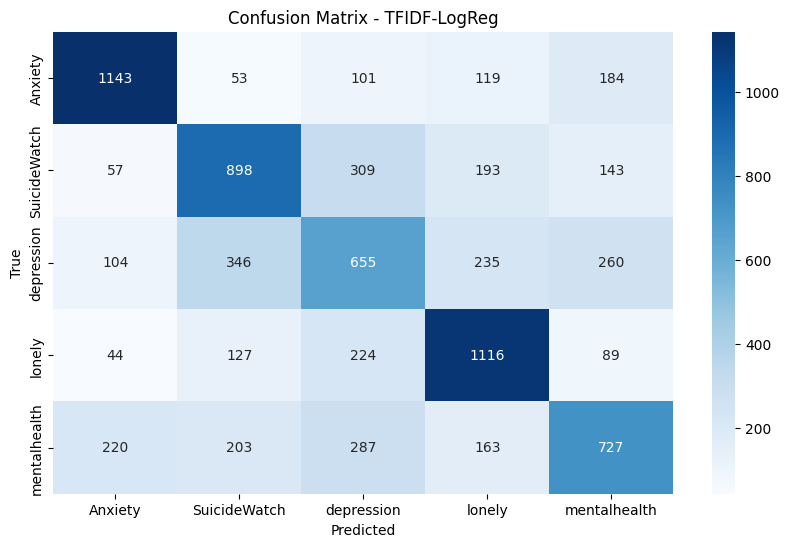

 Model saved to: saved_models\TFIDF_LogisticRegression02.joblib
 TFIDF-SVM Accuracy: 0.557875
              precision    recall  f1-score   support

     Anxiety       0.74      0.69      0.71      1600
SuicideWatch       0.54      0.56      0.55      1600
  depression       0.40      0.42      0.41      1600
      lonely       0.62      0.69      0.65      1600
mentalhealth       0.50      0.44      0.47      1600

    accuracy                           0.56      8000
   macro avg       0.56      0.56      0.56      8000
weighted avg       0.56      0.56      0.56      8000



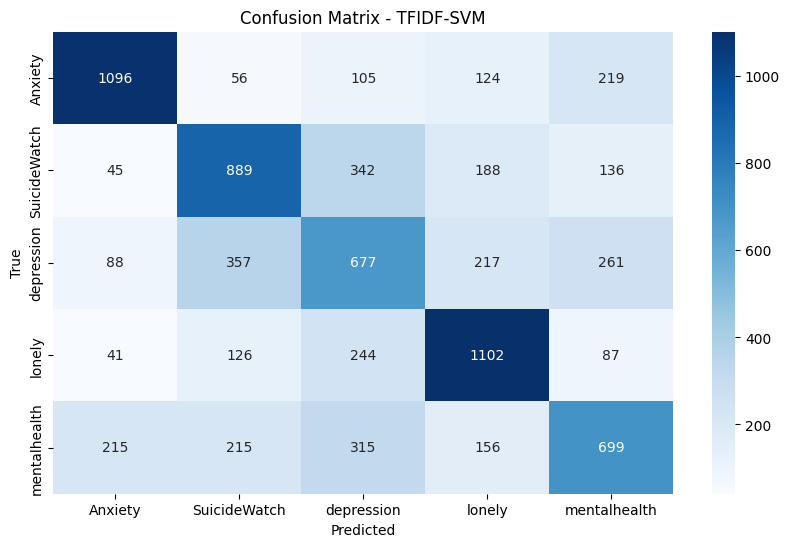

 Model saved to: saved_models\TFIDF_SVM02.joblib


In [27]:
evaluate_model(model_lr, X_test_tfidf, y_test_tfidf, enc_tfidf, "TFIDF-LogReg")
save_model(model_lr, "TFIDF_LogisticRegression02")

evaluate_model(model_svm, X_test_tfidf, y_test_tfidf, enc_tfidf, "TFIDF-SVM")
save_model(model_svm, "TFIDF_SVM02")
